In [ ]:
import tensorflow_datasets as tfds

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')



Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:13 https://

In [ ]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteY3B999/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteY3B999/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteY3B999/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features["label"].names
class_names

['neg', 'pos']

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [ ]:
vocab_size = 10000
batch_size = 32
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
def encode_words(X_batch, y_batch):
    
    return table.lookup(X_batch), y_batch

In [ ]:
train_dtset     = tfds.load('imdb_reviews', split='train', as_supervised=True)
test_dtset      = tfds.load('imdb_reviews', split='test', as_supervised=True)
train_size      = int(train_dtset.cardinality())
val_dtset       = train_dtset.take(int(train_size * 0.15))
train_dtset     = train_dtset.skip(int(train_size * 0.15))

train_size      = int(train_dtset.cardinality())
train_size

21250

In [ ]:
val_size      = int(val_dtset.cardinality())
val_size

3750

In [ ]:
train_set = train_dtset.shuffle(1000).repeat().batch(batch_size).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

test_set = test_dtset.batch(32).map(preprocess).map(encode_words).prefetch(1)

val_set = val_dtset.shuffle(1000).repeat().batch(batch_size).map(preprocess).map(encode_words).prefetch(1)


In [ ]:
embed_size = 128
model = keras.models.Sequential(
    [
        keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
        input_shape=[None]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(128),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam",
metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1408000   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,606,273
Trainable params: 1,606,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, restore_best_weights=True)
Checkpoint = keras.callbacks.ModelCheckpoint("Simple_imdb.h5", save_best_only=True)

In [ ]:
history = model.fit(
    train_set, 
    steps_per_epoch=int(train_size / batch_size),
    validation_data=val_set,
    validation_steps=int(val_size / batch_size),
    epochs=512,
    callbacks=[Early, Checkpoint]
)


Epoch 1/512
664/664 [==============================] - 20s 21ms/step - loss: 0.6398 - accuracy: 0.6131 - val_loss: 0.6024 - val_accuracy: 0.6923
Epoch 2/512
664/664 [==============================] - 13s 20ms/step - loss: 0.4635 - accuracy: 0.7844 - val_loss: 0.4857 - val_accuracy: 0.7735
Epoch 3/512
664/664 [==============================] - 13s 19ms/step - loss: 0.3455 - accuracy: 0.8589 - val_loss: 0.4869 - val_accuracy: 0.7786
Epoch 4/512
664/664 [==============================] - 13s 20ms/step - loss: 0.2274 - accuracy: 0.9153 - val_loss: 0.5933 - val_accuracy: 0.7722
Epoch 5/512
664/664 [==============================] - 13s 20ms/step - loss: 0.1375 - accuracy: 0.9546 - val_loss: 0.7764 - val_accuracy: 0.7599
Epoch 6/512
664/664 [==============================] - 13s 20ms/step - loss: 0.0890 - accuracy: 0.9722 - val_loss: 0.7499 - val_accuracy: 0.7655
Epoch 7/512
664/664 [==============================] - 13s 20ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 1.0953 - val_ac

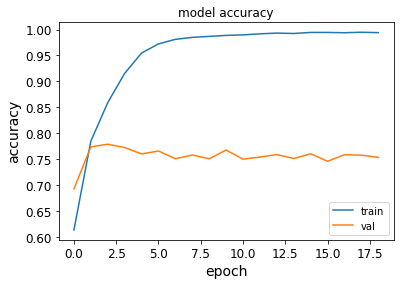

In [ ]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
model.evaluate(test_set)

782/782 [==============================] - 5s 6ms/step - loss: 0.5242 - accuracy: 0.7535


[0.5242043733596802, 0.7534800171852112]

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.projection_dim,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'combine_heads': self.combine_heads,
        })
        return config

In [ ]:

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config


In [ ]:

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,
        input_shape=[None])
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
        input_shape=[None])
        self.maxlen = maxlen

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit= self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config


In [ ]:
embed_dim = embed_size  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 256 


In [ ]:
model2 = keras.models.Sequential(
    [
        keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
        input_shape=[None]),
        TransformerBlock(embed_size, num_heads, ff_dim),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(128),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model2.compile(loss="binary_crossentropy", optimizer="adam",
metrics=["accuracy"])

In [ ]:
Early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=32, restore_best_weights=True)
Checkpoint = keras.callbacks.ModelCheckpoint("Simple_imdb_2.h5", save_best_only=True)

In [ ]:
history = model2.fit(
    train_set, 
    steps_per_epoch=int(train_size / batch_size),
    validation_data=val_set,
    validation_steps=int(val_size / batch_size),
    epochs=512,
    callbacks=[Early, Checkpoint]
)


Epoch 1/512
664/664 [==============================] - 20s 25ms/step - loss: 0.5305 - accuracy: 0.7252 - val_loss: 0.4754 - val_accuracy: 0.7829
Epoch 2/512
664/664 [==============================] - 16s 24ms/step - loss: 0.3415 - accuracy: 0.8560 - val_loss: 0.4877 - val_accuracy: 0.7764
Epoch 3/512
664/664 [==============================] - 16s 24ms/step - loss: 0.1964 - accuracy: 0.9292 - val_loss: 0.6625 - val_accuracy: 0.7393
Epoch 4/512
664/664 [==============================] - 16s 24ms/step - loss: 0.1333 - accuracy: 0.9541 - val_loss: 0.8091 - val_accuracy: 0.7481
Epoch 5/512
664/664 [==============================] - 16s 24ms/step - loss: 0.0968 - accuracy: 0.9683 - val_loss: 0.8924 - val_accuracy: 0.7479
Epoch 6/512
664/664 [==============================] - 16s 24ms/step - loss: 0.0718 - accuracy: 0.9765 - val_loss: 1.0243 - val_accuracy: 0.7577
Epoch 7/512
664/664 [==============================] - 16s 25ms/step - loss: 0.0591 - accuracy: 0.9810 - val_loss: 1.0558 - val_ac

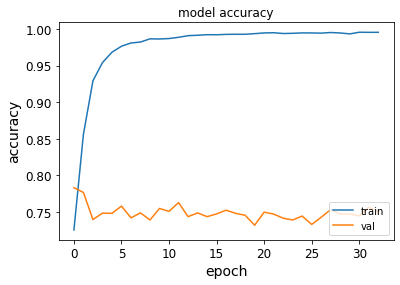

In [ ]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
model2.evaluate(test_set)

782/782 [==============================] - 7s 8ms/step - loss: 0.4959 - accuracy: 0.7650


[0.4959496855735779, 0.7650399804115295]